In [74]:
import pickle

from scipy.stats import norm
from scipy.stats import iqr

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [31]:
SEED = 428
SIZE = 100

SMC_STEPS = 20000
MET_STEPS = 10000

# Data Generation

In [3]:
def gaussian_mixture(mu1=0, sigma1=1,
                     mu2=5, sigma2=2,
                     rho=0.5,
                     size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

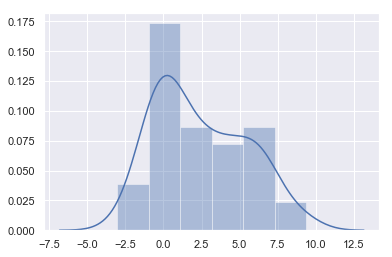

In [4]:
x = gaussian_mixture(rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1
Fit to one Gaussian

In [23]:
with pm.Model() as model_1:
    mu = pm.Uniform("mu", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0, upper=5)
    
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=x)

print(model_1.vars)

[mu_interval__, sigma_interval__]


## Model 2
Two Gaussians with separate mu and sigma. Fix rho at 0.5.

In [24]:
with pm.Model() as model_2:
    w = pm.floatX([.5, .5])
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    #dmu = pm.Uniform("dmu", lower=0, upper=10)
    dmu = pm.Uniform("dmu", lower=3, upper=6)
    
    sigma1 = pm.Uniform("sigma1", lower=0, upper=5)
    #sigma2 = pm.Uniform("sigma2", lower=0, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=1, upper=3)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu1 + dmu)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_2.vars)

[mu1_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__]


## Model 3
Use separate `mu` and `sigma` for both Gaussians. rho uniformly distributed [0, 1].

In [25]:
with pm.Model() as model_3:
    rho = pm.Uniform("rho", lower=0, upper=1)
    
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    dmu = pm.Uniform("dmu", lower=0, upper=10)
    
    sigma1 = pm.Uniform("sigma1", lower=0, upper=5)
    sigma2 = pm.Uniform("sigma2", lower=0, upper=5)
    
    w = tt.zeros([2])
    w = tt.set_subtensor(w[0], rho)
    w = tt.set_subtensor(w[1], 1 - rho)
    
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu1 + dmu)
    
    sigmas = tt.zeros([2])
    sigmas = tt.set_subtensor(sigmas[0], sigma1)
    sigmas = tt.set_subtensor(sigmas[1], sigma2)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_3.vars)

[rho_interval__, mu1_interval__, dmu_interval__, sigma1_interval__, sigma2_interval__]


# Calculation of Bayes factors using sequential MC

## Marginal likelihood

In [ ]:
with model_1:
    tr_smc_m1 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)

pickle.dump(model_1, open("data/model_1.pickle", "wb"))
pickle.dump(tr_smc_m1, open("data/trace_smc_m1.pickle", "wb"))

mllh_m1 = model_1.marginal_likelihood
print("mllh_m1", mllh_m1)
pm.traceplot(tr_smc_m1[::10])

del model_1, mllh_m1

In [ ]:
with model_2:
    tr_smc_m2 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)

pickle.dump(model_2, open("data/model_2.pickle", "wb"))
pickle.dump(tr_smc_m2, open("data/trace_smc_m2.pickle", "wb"))

mllh_m2 = model_2.marginal_likelihood
print("mllh_m2", mllh_m2)
pm.traceplot(tr_smc_m2[::10])

del model_2, mllh_m2

In [ ]:
with model_3:
    tr_smc_m3 = pm.sample(SMC_STEPS, step=pm.SMC(), random_seed=SEED)

pickle.dump(model_3, open("data/model_3.pickle", "wb"))
pickle.dump(tr_smc_m3, open("data/trace_smc_m3.pickle", "wb"))

mllh_m3 = model_3.marginal_likelihood
print("mllh_m3", mllh_m3)
pm.traceplot(tr_smc_m3[::10])

del model_3, mllh_m3

In [13]:
model_1 = pickle.load(open("data/model_1.pickle", "rb"))
mllh_m1 = model_1.marginal_likelihood
print("Log10 Marginal likelihood of model_1: %0.5f" % np.log10(mllh_m1))

model_2 = pickle.load(open("data/model_2.pickle", "rb"))
mllh_m2 = model_2.marginal_likelihood
print("Log10 Marginal likelihood of model_2: %0.5f" % np.log10(mllh_m2))

model_3 = pickle.load(open("data/model_3.pickle", "rb"))
mllh_m3 = model_3.marginal_likelihood
print("Log10 Marginal likelihood of model_3: %0.5f" % np.log10(mllh_m3))

del model_1, model_2, model_3

Log10 Marginal likelihood of model_1: -111.31435
Log10 Marginal likelihood of model_2: -108.18939
Log10 Marginal likelihood of model_3: -108.76529


## Bayes factors

In [14]:
print("Log10 Bayes factor, model_m2 over model_m1: %0.5f" %(np.log10(mllh_m2) - np.log10(mllh_m1)))
print("Log10 Bayes factor, model_m3 over model_m1: %0.5f" %(np.log10(mllh_m3) - np.log10(mllh_m1)))
print("Log10 Bayes factor, model_m3 over model_m2: %0.5f" %(np.log10(mllh_m3) - np.log10(mllh_m2)))

Log10 Bayes factor, model_m2 over model_m1: 3.12495
Log10 Bayes factor, model_m3 over model_m1: 2.54905
Log10 Bayes factor, model_m3 over model_m2: -0.57590


# BAR estimator

In [80]:
def std_from_iqr(data):
    return iqr(data) / 1.35


def fit_normal(x, sigma_robust=False):
    mu, sigma = norm.fit(x)
    if sigma_robust:
        sigma = std_from_iqr(x)
    res = {"mu": mu, "sigma": sigma}
    return res


def fit_normal_trace(trace_values, sigma_robust=False):
    """
    :param trace_values: dict: varname --> ndarray
    :return: dict: varname --> dict: {mu, sigma} -> {float, float}
    """
    res = {varname: fit_normal(trace_values[varname], sigma_robust=sigma_robust) for varname in trace_values}
    return res


def log_normal_pdf(mu, sigma, y):
    """
    :param mu: float
    :param sigma: float
    :param y: float
    :return: float
    """
    sigma2 = sigma * sigma
    res = - 0.5 * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * (y - mu) ** 2
    return res


def log_normal_trace(trace_val, mu_sigma_dict):
    """
    :param trace_val: dict: varname --> ndarray
    :param mu_sigma_dict: dict: varname --> dict: {"mu", "sigma"} -> {float, float}
    :return: ndarray
    """
    keys = list(trace_val.keys())
    k0 = keys[0]
    for k in keys[1:]:
        assert len(trace_val[k0]) == len(trace_val[k]), k0 + " and " + k + " do not have same len."

    nsamples = len(trace_val[k0])
    logp = np.zeros(nsamples, dtype=float)
    for k in keys:
        mu = mu_sigma_dict[k]["mu"]
        sigma = mu_sigma_dict[k]["sigma"]
        y = trace_val[k]
        logp += log_normal_pdf(mu, sigma, y)

    return logp


def draw_normal_samples(mu_sigma_dict, nsamples, random_state=None):
    rand = np.random.RandomState(random_state)
    keys = mu_sigma_dict.keys()
    samples = {k: rand.normal(loc=mu_sigma_dict[k]["mu"], scale=mu_sigma_dict[k]["sigma"], size=nsamples)
               for k in keys}
    return samples

In [78]:
def dict_to_list(dict_of_list):
    """
    :param dict_of_list: dict: varname --> ndarray
    :return: list of dic: [ {varname: float, ...}, ...  ]
    """
    keys = list(dict_of_list.keys())
    key0 = keys[0]
    for key in keys[1:]:
        assert len(dict_of_list[key0]) == len(dict_of_list[key]), key0 + " and " + key + " do not have same len."

    n = len(dict_of_list[key0])
    ls_of_dic = []
    for i in range(n):
        dic = {key: dict_of_list[key][i] for key in keys}
        ls_of_dic.append(dic)
    return ls_of_dic


def get_values_from_trace(model, trace, burn=0):
    varnames = [var.name for var in model.vars]
    trace_values = {var: trace.get_values(var, burn=burn) for var in varnames}
    return trace_values


In [21]:
def log_posterior_trace(model, trace_values):
    model_vars = set([var.name for var in model.vars])
    trace_vars = set(trace_values.keys())
    if model_vars != trace_vars:
        print("model_vars:", model_vars)
        print("trace_vars:", trace_vars)
        raise ValueError("model_vars and trace_vars are not the same set")

    trace_values = dict_to_list(trace_values)
    get_logp = np.vectorize(model.logp)
    logp = get_logp(trace_values)
    return logp


def pot_ener(sample, model):
    """
    :param sample: dict: varname --> ndarray
    :param model: pymc3 model
    :return: ndarray
    """
    u = -log_posterior_trace(model, sample)
    return u


def pot_ener_normal_aug(sample, model, sample_aug, mu_sigma):
    """
    use model to calculate potential energy for sample
    use normal distribution to calculate potential energy for sample_aug
    :param sample: dict: varname --> ndarray
    :param model: pymc3 model
    :param sample_aug: dict: varname --> ndarray
    :param mu_sigma: dict: varname --> dict: {"mu", "sigma"} --> {float, float}
    :return: ndarray
    """
    u1 = -log_posterior_trace(model, sample)
    u2 = -log_normal_trace(sample_aug, mu_sigma)
    u = u1 + u2
    return u


In [61]:
def element_starts_with(start_str, list_of_strs):
    """
    :param start_str: str
    :param list_of_strs: list
    :return: str
    """
    found = [s for s in list_of_strs if s.startswith(start_str)]
    if len(found) == 0:
        raise ValueError("Found none")
    if len(found) > 1:
        raise ValueError("Found many: " + ", ".join(found))
    return found[0]

def split_complex_vars(sample_complex, vars_simple, split_type):
    """
    split set of more complex vars to be used for simpler model
    :param sample_complex: dict: varname --> ndarray, samples drawn from more complex model
    :param vars_simple: list of str, names of vars in simple model
    :param split_type: str, either or "m2_for_m1" or "m3_for_m1" or "m3_for_m2"
    :return: (sample_main, sample_aug), (dict: varname --> ndarray, dict: varname --> ndarray)
    """
    assert split_type in ["m2_for_m1", "m3_for_m1", "m3_for_m2"], "Unknown split_type:" + split_type

    vars_complex = list(sample_complex.keys())
    
    if split_type in ["m2_for_m1", "m3_for_m1"]:
        s_c_pairs = (("mu", "mu1"), ("sigma", "sigma1"))
        sample_main = {}
        for pre_s, pre_c in s_c_pairs:
            var_s = element_starts_with(pre_s, vars_simple)
            var_c = element_starts_with(pre_c, vars_complex)
            sample_main[var_s] = sample_complex[var_c]
        
        if split_type == "m2_for_m1":
            aug_pres = ["dmu", "sigma2"]
        else:
            aug_pres = ["dmu", "sigma2", "rho"]
            
        sample_aug = {}
        for pre_c in aug_pres:
            var_c = element_starts_with(pre_c, vars_complex)
            sample_aug[var_c] = sample_complex[var_c]
        return sample_main, sample_aug


    if split_type == "m3_for_m2":
        common_vars = [var for var in sample_complex.keys() if var != "rho_interval__"]
        sample_main = {var: sample_complex[var] for var in common_vars}

        agu_vars = ["rho_interval__"]
        sample_aug = {var: sample_complex[var] for var in agu_vars}

        return sample_main, sample_aug


def augment_simpler_vars(sample_simpler, mu_sigma_complex, aug_type, random_state=None):
    """
    :param sample_simpler: dict: varname --> ndarray, samples drawn from simpler model
    :param mu_sigma_complex: dict: varname --> dict: {"mu", "sigma"} --> {float, float}
                                  mu and sigma estimated from samples drawn from more complex model
    :param aug_type: str, either "m1_for_m2", "m1_for_m3", or "m2_for_m3"
    :param random_state: int
    :return: (sample_main, sample_aug), (dict: varname --> ndarray, dict: varname --> ndarray)
    """
    assert aug_type in ["m1_for_m2", "m1_for_m3", "m2_for_m3"], "Unknown aug_type:" + aug_type

    # make sure we get correct mu_sigma_complex
    if aug_type == "m1_for_m2":
        assert "dmu_interval__" in mu_sigma_complex, "dmu_interval__ not in mu_sigma_complex"
        assert "rho_interval__" not in mu_sigma_complex, "rho_interval__ in mu_sigma_complex"

    if aug_type in ["m1_for_m3", "m2_for_m3"]:
        assert "rho_interval__" in mu_sigma_complex, "rho_interval__ not in mu_sigma_complex"

    vars_simple = list(sample_simpler.keys())
    vars_complex = list(mu_sigma_complex.keys())
    nsamples = len(sample_simpler[vars_simple[0]])
    
    if aug_type in ["m1_for_m2", "m1_for_m3"]:
        c_s_pairs = (("mu1", "mu"), ("sigma1", "sigma"))
        
        sample_main = {}
        for pre_c, pre_s in c_s_pairs:
            var_c = element_starts_with(pre_c, vars_complex)
            var_s = element_starts_with(pre_s, vars_simple)
            sample_main[var_c] = sample_simpler[var_s]
        
        if aug_type == "m1_for_m2":
            aug_pres = ["dmu", "sigma2"]
        else:
            aug_pres = ["dmu", "sigma2", "rho"]
        
        mu_sigma_aug = {}
        for pre_c in aug_pres:
            var_c = element_starts_with(pre_c, vars_complex)
            mu_sigma_aug[var_c] = mu_sigma_complex[var_c]
        sample_aug = draw_normal_samples(mu_sigma_aug, nsamples, random_state=random_state)
        
        return sample_main, sample_aug

    if aug_type == "m2_for_m3":
        common_vars = [var for var in sample_simpler.keys() if var != "rho_interval__"]
        sample_main = {var: sample_simpler[var] for var in common_vars}

        aug_vars = ["rho_interval__"]
        mu_sigma_aug = {k: mu_sigma_complex[k] for k in aug_vars}
        sample_aug = draw_normal_samples(mu_sigma_aug, nsamples, random_state=random_state)

        return sample_main, sample_aug


In [76]:
def bootstrap_BAR(w_F, w_R, repeats):
    """
    :param w_F: ndarray
    :param w_R: ndarray
    :param repeats: int
    :return: std, float
    """
    n_F = len(w_F)
    n_R = len(w_R)
    delta_Fs = []
    for _ in range(repeats):
        w_F_rand = np.random.choice(w_F, size=n_F, replace=True)
        w_R_rand = np.random.choice(w_R, size=n_R, replace=True)

        df = pymbar.BAR(w_F_rand, w_R_rand, compute_uncertainty=False, relative_tolerance=1e-6, verbose=False)
        delta_Fs.append(df)

    delta_Fs = np.asarray(delta_Fs)
    delta_Fs = delta_Fs[~np.isnan(delta_Fs)]
    delta_Fs = delta_Fs[~np.isinf(delta_Fs)]

    return delta_Fs.std()


def bayes_factor(model_ini, sample_ini, model_fin, sample_fin,
                 model_ini_name, model_fin_name,
                 sigma_robust=False, random_state=None,
                 bootstrap=None):
    """
    :param model_ini: pymc3 model
    :param sample_ini: dict: varname --> ndarray, samples drawn from initial (simpler) state
    :param model_fin: pymc3 model
    :param sample_fin: dict: varname --> ndarray, samples drawn from final (more complex) state
    :param model_ini_name: str
    :param model_fin_name: str
    :param sigma_robust: bool
    :param random_state: int
    :param bootstrap: int
    :return: float
    """
    mu_sigma_fin = fit_normal_trace(sample_fin, sigma_robust=sigma_robust)
    print("mu_sigma_fin:", mu_sigma_fin)

    split_type = model_fin_name + "_for_" + model_ini_name
    aug_type = model_ini_name + "_for_" + model_fin_name

    # augment initial sample
    sample_i_for_f, sample_ini_aug = augment_simpler_vars(sample_ini, mu_sigma_fin, aug_type,
                                                          random_state=random_state)
    # split final sample
    sample_f_for_i, sample_fin_aug = split_complex_vars(sample_fin, sample_ini.keys(), split_type)

    # potential for sample drawn from i estimated at state i
    print("Calculate u_i_i: drawn from i, estimated at i")
    u_i_i = pot_ener_normal_aug(sample_ini, model_ini, sample_ini_aug, mu_sigma_fin)

    # potential for sample drawn from i estimated at state f
    sample_ini_comb = sample_i_for_f.copy()
    sample_ini_comb.update(sample_ini_aug)
    print("Calculate u_i_f: drawn from i, estimated at f")
    u_i_f = pot_ener(sample_ini_comb, model_fin)

    #
    # potential for sample drawn from f estimated at state f
    print("Calculate u_f_f: drawn from f, estimated at f")
    u_f_f = pot_ener(sample_fin, model_fin)

    # potential for sample drawn from f estimated at state i
    print("Calculate u_f_i: drawn from f, estimated at i")
    u_f_i = pot_ener_normal_aug(sample_f_for_i, model_ini, sample_fin_aug, mu_sigma_fin)

    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

# Metropolis sampling

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3803.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a3bd208>,
      dtype=object)

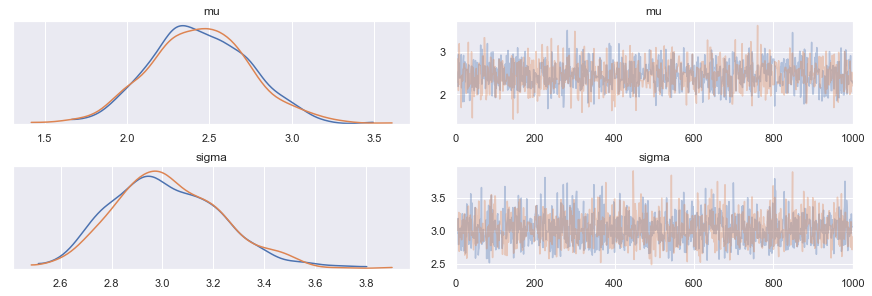

In [32]:
with model_1:
    tr_met_m1 = pm.sample(MET_STEPS, step=pm.Metropolis(), random_seed=SEED)

pickle.dump(tr_met_m1, open("data/trace_met_m1.pickle", "wb"))

pm.traceplot(tr_met_m1[::10])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [sigma1]
>Metropolis: [dmu]
>Metropolis: [mu1]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:11<00:00, 1881.19draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d764b00>,
      dtype=object)

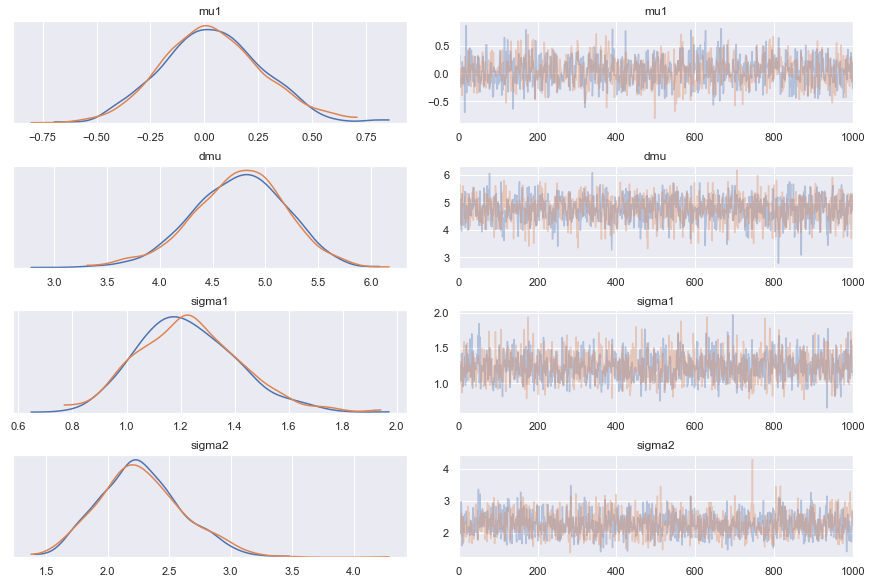

In [33]:
with model_2:
    tr_met_m2 = pm.sample(MET_STEPS, step=pm.Metropolis(), random_seed=SEED)

pickle.dump(tr_met_m2, open("data/trace_met_m2.pickle", "wb"))

pm.traceplot(tr_met_m2[::10])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [sigma1]
>Metropolis: [dmu]
>Metropolis: [mu1]
>Metropolis: [rho]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:15<00:00, 1372.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ed9a0b8>,
      dtype=object)

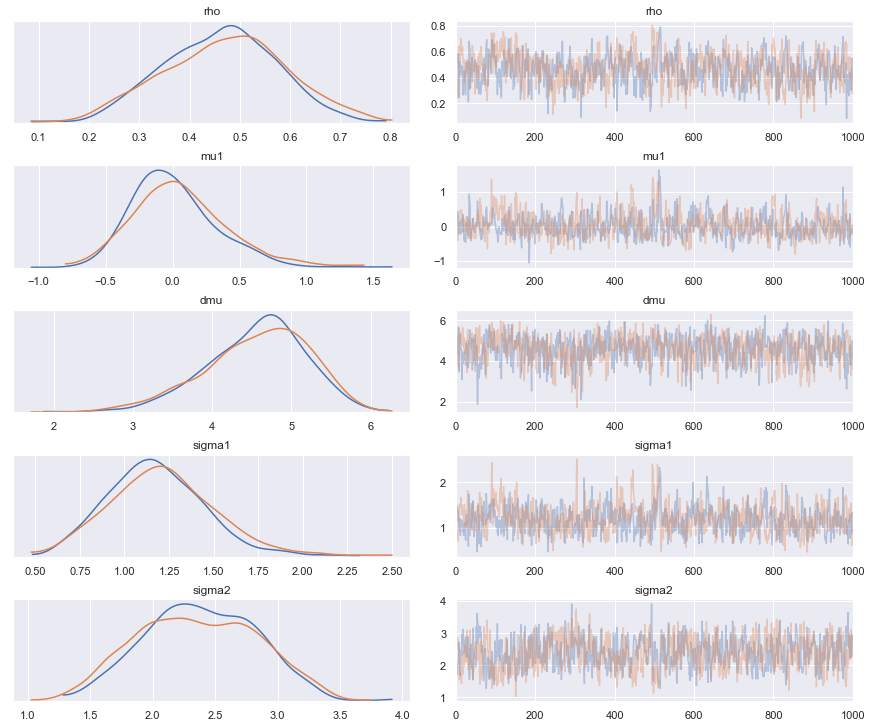

In [34]:
with model_3:
    tr_met_m3 = pm.sample(MET_STEPS, step=pm.Metropolis(), random_seed=SEED)

pickle.dump(tr_met_m3, open("data/trace_met_m3.pickle", "wb"))

pm.traceplot(tr_met_m3[::10])

In [37]:
tr_val_met_m1 = get_values_from_trace(model_1, tr_met_m1)
tr_val_met_m2 = get_values_from_trace(model_2, tr_met_m2)
tr_val_met_m3 = get_values_from_trace(model_3, tr_met_m3)

In [40]:
print("tr_val_met_m1 keys:", tr_val_met_m1.keys())
print("tr_val_met_m2 keys:", tr_val_met_m2.keys())
print("tr_val_met_m3 keys:", tr_val_met_m3.keys())

tr_val_met_m1 keys: dict_keys(['mu_interval__', 'sigma_interval__'])
tr_val_met_m2 keys: dict_keys(['mu1_interval__', 'dmu_interval__', 'sigma1_interval__', 'sigma2_interval__'])
tr_val_met_m3 keys: dict_keys(['rho_interval__', 'mu1_interval__', 'dmu_interval__', 'sigma1_interval__', 'sigma2_interval__'])


# Bayes factors using BAR

bayes_factor(model_ini, sample_ini, model_fin, sample_fin,
                 model_ini_name, model_fin_name,
                 sigma_robust=False, random_state=None,
                 bootstrap=None):

In [81]:
bf_m2_over_m1 = bayes_factor(model_1, tr_val_met_m1, model_2, tr_val_met_m2,
                            "m1", "m2", sigma_robust=True, random_state=123, bootstrap=100)

mu_sigma_fin: {'mu1_interval__': {'mu': 0.007899963312155468, 'sigma': 0.0466546286516067}, 'dmu_interval__': {'mu': -0.10357931759725868, 'sigma': 0.17417510293141045}, 'sigma1_interval__': {'mu': -1.1338686817410621, 'sigma': 0.20150409894890428}, 'sigma2_interval__': {'mu': -0.179738570398676, 'sigma': 0.26529281180214187}}
Calculate u_i_i: drawn from i, estimated at i
Calculate u_i_f: drawn from i, estimated at f
Calculate u_f_f: drawn from f, estimated at f
Calculate u_f_i: drawn from f, estimated at i
relative_change =        1.000
iteration     0: DeltaF =          -26.909
relative_change =        0.037
iteration     1: DeltaF =          -25.960
relative_change =        0.003
iteration     2: DeltaF =          -26.033
relative_change =        0.000
Convergence achieved.
Converged to tolerance of 6.277683e-15 in 3 iterations (6 function evaluations)
DeltaF =  -26.033
Running 100 bootstraps to estimate error.
ln(bf) = 26.03267 +/- 1.88218


In [83]:
26.03267* np.log10(np.e)

11.305844930208327

In [82]:
bf_m3_over_m1 = bayes_factor(model_1, tr_val_met_m1, model_3, tr_val_met_m3,
                            "m1", "m3", sigma_robust=True, random_state=123, bootstrap=100)

mu_sigma_fin: {'rho_interval__': {'mu': -0.1476413680075934, 'sigma': 0.4807739649043908}, 'mu1_interval__': {'mu': 0.007915860746429694, 'sigma': 0.06308173336236828}, 'dmu_interval__': {'mu': -0.17873671341524672, 'sigma': 0.24999460949832353}, 'sigma1_interval__': {'mu': -1.1784767261622546, 'sigma': 0.3010164618693948}, 'sigma2_interval__': {'mu': -0.10183792214662636, 'sigma': 0.4042071826368793}}
Calculate u_i_i: drawn from i, estimated at i
Calculate u_i_f: drawn from i, estimated at f
Calculate u_f_f: drawn from f, estimated at f
Calculate u_f_i: drawn from f, estimated at i
relative_change =        1.000
iteration     0: DeltaF =          -10.971
relative_change =        0.048
iteration     1: DeltaF =          -10.471
relative_change =        0.008
iteration     2: DeltaF =          -10.552
relative_change =        0.000
iteration     3: DeltaF =          -10.552
relative_change =        0.000
iteration     4: DeltaF =          -10.552
relative_change =        0.000
Convergen

In [84]:
10.55160* np.log10(np.e)

4.582501655250352

In [85]:
bf_m3_over_m2 = bayes_factor(model_2, tr_val_met_m2, model_3, tr_val_met_m3,
                            "m2", "m3", sigma_robust=True, random_state=123, bootstrap=100)

mu_sigma_fin: {'rho_interval__': {'mu': -0.1476413680075934, 'sigma': 0.4807739649043908}, 'mu1_interval__': {'mu': 0.007915860746429694, 'sigma': 0.06308173336236828}, 'dmu_interval__': {'mu': -0.17873671341524672, 'sigma': 0.24999460949832353}, 'sigma1_interval__': {'mu': -1.1784767261622546, 'sigma': 0.3010164618693948}, 'sigma2_interval__': {'mu': -0.10183792214662636, 'sigma': 0.4042071826368793}}
Calculate u_i_i: drawn from i, estimated at i
Calculate u_i_f: drawn from i, estimated at f
Calculate u_f_f: drawn from f, estimated at f
Calculate u_f_i: drawn from f, estimated at i
relative_change =        1.000
iteration     0: DeltaF =            1.197
relative_change =        0.000
iteration     1: DeltaF =            1.197
relative_change =        0.000
iteration     2: DeltaF =            1.197
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 3 iterations (6 function evaluations)
DeltaF =    1.197
Running 100 bootstraps to estimate error.
ln(bf) = -1.19740 +/- 0.00

In [86]:
-1.19740 * np.log10(np.e)

-0.5200242126309538